### Introduction 
<br/>
Purpose of this notebook

### Import Libraries

In [1]:
import os, sys, time, gc, warnings, re 
import datetime as dt

import itertools as it
import operator as op

import numpy as np
import scipy.stats as stats
import scipy as sp
import pandas as pd

import statsmodels.tsa as smt

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML, Markdown

sys.path.append(os.environ["PY_UTILITIES_LIBRARY"]) # PY_UTILITIES_LIBRARY points to our custom library

%matplotlib inline

In [2]:
%reload_ext watermark
%watermark -iv -d -t -v -w -m

scipy     1.3.0
json      2.0.9
numpy     1.16.4
re        2.2.1
matplotlib3.0.3
pandas    0.24.2
seaborn   0.9.0
statsmodels0.9.0
2019-06-09 05:53:59 

CPython 3.6.8
IPython 7.5.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores  : 12
interpreter: 64bit
watermark 1.8.0


### Configure Notebook

In [3]:
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)
pd.set_option("display.max_colwidth", -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('io.hdf.default_format','fixed') # store binary data in HDF5 'table' format or 'fixed' format
sns.set(context='paper', style="darkgrid", rc={'axes.labelcolor': 'black', 'xtick.color': 'black', 'ytick.color': 'black', 'figure.facecolor':'white'}, 
        font_scale=1.3)
HTML("<style>table {font-size:14px} </style>")

def printmd(string, color=None):
    """colors in hex"""
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [4]:
%reload_ext autoreload
%autoreload 2

rs_seed = np.random.RandomState(seed=43)
warnings.filterwarnings("ignore")

### Define Notebook Parameters

In [5]:
# see papermill package
root_dir = "./av_train"
train_csv = "train.csv"
train_dir = "train_images"
test_dir = "test_images"

In [6]:
# imports
import shutil
from tqdm import tqdm_notebook

from ml_toolbelt.image_processing.image_utils import get_image_paths, get_labels

In [7]:
label_dict = {'Cargo': 1, 
              'Military': 2, 
              'Carrier': 3, 
              'Cruise': 4, 
              'Tankers': 5}

rev_label_dict = {y:x for x,y in label_dict.items()}

In [13]:
# imports
from fastai.vision import *

from fastai import metrics as fa_metrics
from fastai.basic_train import *
from fastai.train import *
from fastai.callbacks import *
from fastai.data_block import *

from fastai.utils import mem
from fastai.callbacks.mem import PeakMemMetric

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
from PIL import Image as pil_image # faster reads without loading into memory

from functools import partial

In [36]:
# reload again
all_image_paths = get_image_paths(root_dir+"/"+train_dir)
all_image_labels = get_labels(root_dir+"/"+train_dir, all_image_paths, use_label_encoder=False)

# label encode targets
all_image_labels = [label_dict[x] for x in all_image_labels]
all_image_labels[:10]

Root Dir: av_train\train_images
Shuffling image paths...
Number of images: 6252
Root Dir: av_train\train_images

Labels:
['Cargo', 'Carrier', 'Cruise', 'Military', 'Tankers']

Number of labels: 5
Number of images: 6252


[5, 4, 1, 5, 2, 2, 3, 3, 2, 1]

In [37]:
# create a dataframe of image path and labels
# path | label_integer | class_name
img_df = pd.DataFrame({"img_path": all_image_paths, "target": all_image_labels, "class": [rev_label_dict[x] for x in all_image_labels]})
print(img_df.shape)
img_df.head()

(6252, 3)


,img_path,target,class
0,av_train\train_images\Tankers\2839638.jpg,5,Tankers
1,av_train\train_images\Cruise\2589495.jpg,4,Cruise
2,av_train\train_images\Cargo\2825233.jpg,1,Cargo
3,av_train\train_images\Tankers\2866010.jpg,5,Tankers
4,av_train\train_images\Military\907161.jpg,2,Military


In [38]:
# validation indices
train_df, valid_df = train_test_split(img_df, test_size=0.2, stratify=img_df["target"], shuffle=True, random_state=rs_seed)

train_df["is_valid"] = False
valid_df["is_valid"] = True
img_df = pd.concat([train_df, valid_df], axis=0)

del train_df, valid_df
gc.collect()

print(img_df.shape)
img_df.head()

(6252, 4)


,img_path,target,class,is_valid
365,av_train\train_images\Cargo\2902711.jpg,1,Cargo,False
5234,av_train\train_images\Cargo\2802622.jpg,1,Cargo,False
1911,av_train\train_images\Cargo\2800528.jpg,1,Cargo,False
4204,av_train\train_images\Tankers\2798466.jpg,5,Tankers,False
5735,av_train\train_images\Cruise\597093.jpg,4,Cruise,False


In [44]:
# get height and width
def getSize(flname):
    # file size in bytes
    img_size = pil_image.open(flname).size
    return flname, os.stat(flname).st_size, img_size[1], img_size[0]

size_df = pd.DataFrame(img_df.apply(lambda x: getSize(x["img_path"]), axis=1).tolist(), columns = ["img_path", "size", "height", "width"])
img_df = img_df.merge(size_df, on="img_path", how="left")

del size_df
gc.collect()
img_df.head()

,img_path,target,class,is_valid,size,height,width
0,av_train\train_images\Cargo\2902711.jpg,1,Cargo,False,11748,140,210
1,av_train\train_images\Cargo\2802622.jpg,1,Cargo,False,18966,140,210
2,av_train\train_images\Cargo\2800528.jpg,1,Cargo,False,9576,158,210
3,av_train\train_images\Tankers\2798466.jpg,5,Tankers,False,8790,126,210
4,av_train\train_images\Cruise\597093.jpg,4,Cruise,False,11922,143,210


In [48]:
# average dimensions of the images
print("Height:", img_df["height"].mean(), "+/-", img_df["height"].std())
print("Width:", img_df["width"].mean(), "+/-", img_df["width"].std())

Height: 138.9796865003199 +/- 15.9452872937359
Width: 209.05630198336533 +/- 8.373883780156067


In [51]:
# image databunch
db = ImageList.from_df(img_df, ".", convert_mode="RGB")
db = db.split_from_df(col="is_valid")  # split_none()
db = db.label_from_df(cols="target"). \
        transform(tfms=get_transforms(), size=(160, 224), tfm_y=False). \
        databunch(bs=64, val_bs=None, num_workers=4, device=None)
# resize_method=ResizeMethod.SQUISH in transform()

# scale
db = db.normalize(imagenet_stats)
db

ImageDataBunch;

Train: LabelList (5001 items)
x: ImageList
Image (3, 160, 224),Image (3, 160, 224),Image (3, 160, 224),Image (3, 160, 224),Image (3, 160, 224)
y: CategoryList
1,1,1,5,4
Path: .;

Valid: LabelList (1251 items)
x: ImageList
Image (3, 160, 224),Image (3, 160, 224),Image (3, 160, 224),Image (3, 160, 224),Image (3, 160, 224)
y: CategoryList
1,4,3,1,1
Path: .;

Test: None

In [52]:
print(db.classes)
print(db.c)
# per channel pixel means
print( db.batch_stats(ds_type=DatasetType.Train) )

[1, 2, 3, 4, 5]
5
[tensor([0.1802, 0.4848, 0.9307]), tensor([1.0763, 1.0581, 1.1067])]


In [53]:
# convenience functions
def clear_session():
    torch.cuda.empty_cache()
    gc.collect()
    print(mem.gpu_mem_get_all())
    
def get_total_steps(db, bs=32, total_epochs=20, warm_up_pct=0.3):
    # steps_per_epoch or # of batches / batch updates per epoch
    total_steps = len(db.train_ds) // bs * total_epochs # total batch updates
    print("Steps per epoch: {}".format(len(db.train_ds) // bs))
    print("Total steps: {}".format(total_steps))
    print("Warm up steps: {}".format(int(total_steps * warm_up_pct)))

### Densenet

In [54]:
# custom metric
def f1_weighted(preds, actual):
    preds = np.argmax(preds, axis=1)
    val = metrics.f1_score(actual, preds, average="weighted")
    return torch.Tensor([val]).cuda()

In [55]:
# train
learner121 = cnn_learner(db, models.densenet121, metrics=[f1_weighted], model_dir="./models", 
                          callback_fns=[PeakMemMetric])
                                    #partial(EarlyStoppingCallback, monitor="f1_weighted", mode="max", patience=5, min_delta=0.01), # 1% improvement
                                    #partial(SaveModelCallback, monitor="f1_weighted", mode="max", every="improvement", name="resnet50_bestmodel")]) # ps=0, wd=0, PeakMemMetric
learner121.summary()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\sneha/.torch\models\densenet121-a639ec97.pth
32342954it [00:01, 18698567.51it/s]


Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 80, 112]        9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 80, 112]        128        True      
______________________________________________________________________
ReLU                 [64, 80, 112]        0          False     
______________________________________________________________________
MaxPool2d            [64, 40, 56]         0          False     
______________________________________________________________________
BatchNorm2d          [64, 40, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 40, 56]         0          False     
______________________________________________________________________
Conv2d               [128, 40, 56]        8,192      False     
______________________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-03
0.001445439770745928


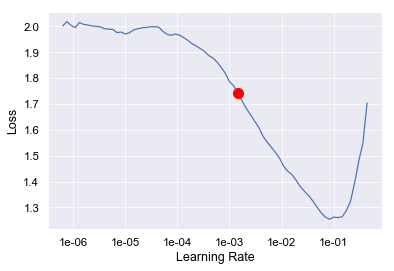

In [56]:
learner121.lr_find()
learner121.recorder.plot(suggestion=True, return_fig=True)
print(learner121.recorder.min_grad_lr)

In [57]:
print(len(learner121.layer_groups))

3


In [70]:
# a cycle of 8 epochs
learner121.fit_one_cycle(10, max_lr=1e-02, pct_start=0.1)

epoch,train_loss,valid_loss,f1_weighted,cpu used,peak,gpu used,peak,time
0,0.369247,3.406665,0.499637,0,3,42,6184,01:15
1,0.353714,0.454257,0.858505,0,3,0,6182,01:17
2,0.299669,0.271218,0.902691,0,3,0,6182,01:16
3,0.240684,0.306697,0.903602,0,3,0,6182,01:15
4,0.200625,0.314434,0.897116,0,3,0,6182,01:16
5,0.156593,0.264453,0.913760,0,3,0,6182,01:16
6,0.123379,0.213045,0.923836,0,3,0,6182,01:16
7,0.091177,0.181895,0.939414,0,3,0,6182,01:16
8,0.068095,0.176848,0.938598,0,3,0,6182,01:16
9,0.054285,0.178303,0.940048,0,3,0,6182,01:16


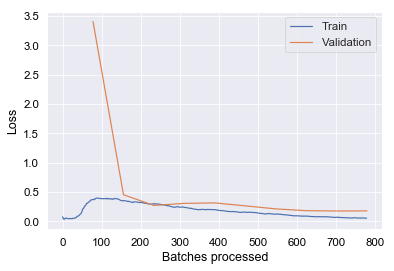

In [71]:
learner121.recorder.plot_losses()

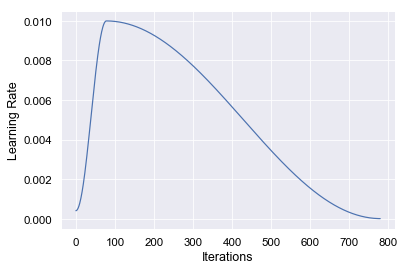

In [75]:
learner121.recorder.plot_lr()

In [73]:
learner121.save("densenet121_model")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
6.309573444801933e-07


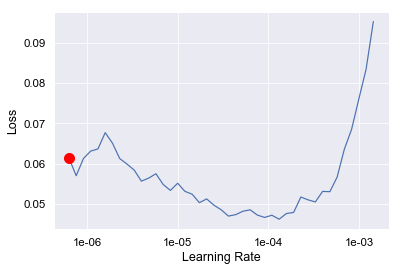

In [76]:
# unfreeze
learner121.unfreeze()

learner121.lr_find()
learner121.recorder.plot(suggestion=True, return_fig=True)
print(learner121.recorder.min_grad_lr)

In [80]:
learner121.fit_one_cycle(20, max_lr=slice(1e-4), pct_start=0.1)

epoch,train_loss,valid_loss,f1_weighted,cpu used,peak,gpu used,peak,time
0,0.048503,0.174451,0.939424,0,3,99,6169,01:28
1,0.043413,0.176542,0.942086,0,3,0,6058,01:29
2,0.040817,0.178099,0.942679,0,3,0,6058,01:29
3,0.039995,0.176982,0.938726,0,3,0,6058,01:30
4,0.035232,0.179523,0.940846,0,3,0,6058,01:29
5,0.038510,0.179608,0.938548,0,3,0,6058,01:30
6,0.035293,0.179378,0.938201,0,3,0,6058,01:29
7,0.035831,0.179246,0.944282,0,3,0,6058,01:30
8,0.034263,0.185734,0.941640,0,3,0,6058,01:29
9,0.033838,0.191948,0.943380,0,3,0,6058,01:30


In [81]:
learner121.save("densenet121_model_unfreezed")

In [82]:
# explore!
learner121.fit_one_cycle(20, max_lr=slice(1e-4), pct_start=0.7, 
                         callbacks=[SaveModelCallback(learner121, monitor="f1_weighted", mode="max", every="improvement", name="densenet121_bestmodel")])

epoch,train_loss,valid_loss,f1_weighted,cpu used,peak,gpu used,peak,time
0,0.020229,0.186174,0.939393,0,3,43,6058,01:27
1,0.024899,0.188300,0.941069,0,3,0,6058,01:30
2,0.024414,0.188474,0.940298,0,3,0,6058,01:30
3,0.025732,0.191022,0.941170,0,3,0,6058,01:30
4,0.024149,0.189038,0.941130,0,3,0,6058,01:31
5,0.024274,0.189365,0.942759,0,3,0,6058,01:31
6,0.022061,0.188449,0.942832,0,3,0,6058,01:31
7,0.019499,0.186493,0.938806,0,3,0,6058,01:31
8,0.025299,0.203251,0.941595,0,3,0,6058,01:30
9,0.021292,0.190396,0.938766,0,3,0,6058,01:31


Better model found at epoch 0 with f1_weighted value: 0.9393925070762634.
Better model found at epoch 1 with f1_weighted value: 0.941069483757019.
Better model found at epoch 3 with f1_weighted value: 0.941169798374176.
Better model found at epoch 5 with f1_weighted value: 0.9427589774131775.
Better model found at epoch 6 with f1_weighted value: 0.9428317546844482.
Better model found at epoch 12 with f1_weighted value: 0.9436090588569641.
Better model found at epoch 15 with f1_weighted value: 0.9451667070388794.
Better model found at epoch 19 with f1_weighted value: 0.9458429217338562.


In [83]:
# explain
intrp = ClassificationInterpretation.from_learner(learner121, ds_type=DatasetType.Train)

In [85]:
intrp.most_confused(min_val=2)

[(1, 2, 2), (5, 1, 2)]

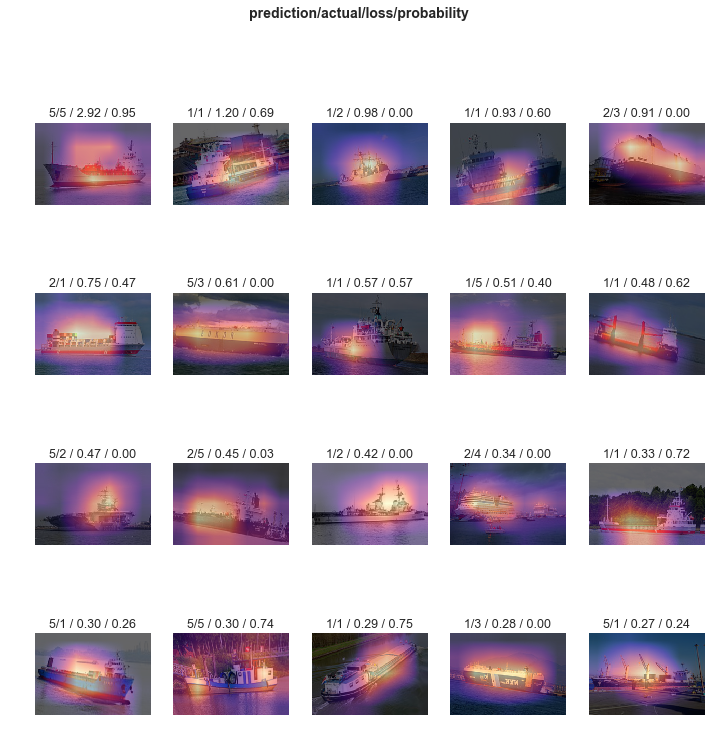

In [86]:
intrp.plot_top_losses(20)

In [87]:
# TTA ; Oversampling
preds = learner121.TTA(ds_type=DatasetType.Valid) # retuns tuple of torch ndarray of n x classes, actual labels
y_pred = np.argmax(preds[0].numpy(), axis=1)
metrics.f1_score(preds[1].numpy(), y_pred, average="weighted")

0.9496551339640809

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
6.309573444801933e-07


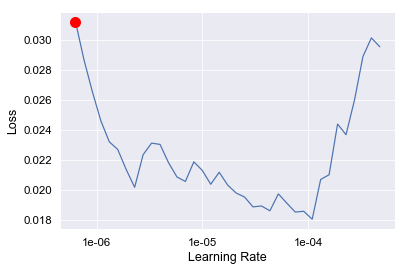

In [118]:
# L2 reg
learner121.lr_find(wd=0.01)
learner121.recorder.plot(suggestion=True, return_fig=True)
print(learner121.recorder.min_grad_lr)

In [123]:
# train with L2 reg
learner121.fit_one_cycle(10, max_lr=slice(8e-5), pct_start=0.1, wd=0.01,
                         callbacks=[SaveModelCallback(learner121, monitor="f1_weighted", mode="max", every="improvement", name="densenet121_bestmodel_wd")])

epoch,train_loss,valid_loss,f1_weighted,cpu used,peak,gpu used,peak,time
0,0.014394,0.203121,0.946560,0,3,69,6028,01:26
1,0.016207,0.207245,0.940002,0,3,-25,6028,01:27
2,0.015285,0.211452,0.942386,0,3,-1,6053,01:26
3,0.021286,0.203624,0.942063,0,3,0,6055,01:27
4,0.012733,0.214639,0.942575,0,3,26,6029,01:26
5,0.011356,0.206545,0.944057,0,3,-25,6029,01:26
6,0.011375,0.202916,0.945907,0,3,-1,6053,01:30
7,0.013175,0.203090,0.945828,0,3,0,6055,01:26
8,0.011078,0.206450,0.945853,0,3,26,6029,01:25
9,0.012522,0.202837,0.945880,0,3,-25,6029,01:28


Better model found at epoch 0 with f1_weighted value: 0.9465604424476624.


In [88]:
# prepare test set
root_path = Path(root_dir)
test_files = [root_path/test_dir/x for x in os.listdir(root_path/test_dir)]
print(test_files[:5])

db.add_test(test_files, label=None)
db

[WindowsPath('av_train/test_images/1007700.jpg'), WindowsPath('av_train/test_images/1011369.jpg'), WindowsPath('av_train/test_images/1051155.jpg'), WindowsPath('av_train/test_images/1062001.jpg'), WindowsPath('av_train/test_images/1069397.jpg')]


ImageDataBunch;

Train: LabelList (5001 items)
x: ImageList
Image (3, 160, 224),Image (3, 160, 224),Image (3, 160, 224),Image (3, 160, 224),Image (3, 160, 224)
y: CategoryList
1,1,1,5,4
Path: .;

Valid: LabelList (1251 items)
x: ImageList
Image (3, 160, 224),Image (3, 160, 224),Image (3, 160, 224),Image (3, 160, 224),Image (3, 160, 224)
y: CategoryList
1,4,3,1,1
Path: .;

Test: LabelList (2680 items)
x: ImageList
Image (3, 160, 224),Image (3, 160, 224),Image (3, 160, 224),Image (3, 160, 224),Image (3, 160, 224)
y: EmptyLabelList
,,,,
Path: .

In [89]:
# predictions with oversampling
test_preds = learner121.TTA(ds_type=DatasetType.Test)
y_test = np.argmax(test_preds[0], axis=1) + 1
test_df = pd.DataFrame({'image': [x.name for x in db.test_ds.x.items], "category": y_test})
print(test_df.shape)

test_df.to_csv("./submission_densenet121_aug.csv", index=False)
test_df.head()

# LEADERBOARD SCORE: 0.9532

(2680, 2)


,image,category
0,1007700.jpg,4
1,1011369.jpg,4
2,1051155.jpg,4
3,1062001.jpg,2
4,1069397.jpg,4


In [91]:
# predictions without oversampling
try_preds, _ = learner121.get_preds(ds_type=DatasetType.Test)
test_df["category_prob"] = np.max(test_preds[0].numpy(), axis=1)
test_df["pred_wo_sampling"] = (np.argmax(try_preds, axis=1) + 1).numpy()
test_df["pred_wo_sampling_prob"] = np.max(try_preds.numpy(), axis=1)

test_df.head()

,image,category,category_prob,pred_wo_sampling,pred_wo_sampling_prob
0,1007700.jpg,4,0.999,4,1.000
1,1011369.jpg,4,1.000,4,1.000
2,1051155.jpg,4,0.997,4,1.000
3,1062001.jpg,2,1.000,2,1.000
4,1069397.jpg,4,0.769,4,1.000


In [92]:
# differences in confidence in predictions between no sampling vs. oversampling
def choose_largest(x):
    if x["category_prob"] > x["pred_wo_sampling_prob"]:
        return x["category"]
    return x["pred_wo_sampling"]

test_df["new_category"] = test_df.apply(lambda x: x["category"] if x["category"] == x["pred_wo_sampling"] else choose_largest(x), axis=1)
test_df.head()

,image,category,category_prob,pred_wo_sampling,pred_wo_sampling_prob,new_category
0,1007700.jpg,4,0.999,4,1.000,4
1,1011369.jpg,4,1.000,4,1.000,4
2,1051155.jpg,4,0.997,4,1.000,4
3,1062001.jpg,2,1.000,2,1.000,2
4,1069397.jpg,4,0.769,4,1.000,4


In [93]:
test_df[test_df["category"] != test_df["pred_wo_sampling"]]

,image,category,category_prob,pred_wo_sampling,pred_wo_sampling_prob,new_category
72,1440259.jpg,4,0.538,1,0.966,1
115,1642121.jpg,4,0.557,1,0.507,4
119,1651833.jpg,2,0.564,4,0.502,2
190,1905582.jpg,2,0.477,1,0.587,1
207,2006104.jpg,4,0.435,1,0.546,1
221,2042418.jpg,1,0.423,4,0.885,4
245,2127813.jpg,2,0.627,1,0.632,1
328,2360965.jpg,4,0.691,1,0.429,4
359,2465197.jpg,2,0.654,1,0.509,2
421,2659840.jpg,2,0.643,1,0.622,2


In [94]:
test_new_df = test_df[["image", "new_category"]].rename(columns = {"new_category": "category"})
test_new_df.head()

,image,category
0,1007700.jpg,4
1,1011369.jpg,4
2,1051155.jpg,4
3,1062001.jpg,2
4,1069397.jpg,4


In [95]:
test_new_df.to_csv("./submission_densenet121_mixed.csv", index=False)
# LEADERBOARD SCORE: 0.9485